In [351]:
import pandas as pd
import plotly.express as px
import numpy as np
from sklearn.preprocessing import  StandardScaler, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering, KMeans,MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import KElbowVisualizer
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import  StandardScaler
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.decomposition import PCA

## Data Preprocess

In [ ]:
data = pd.read_csv('NOVAIMS_MAA_2020e21_BusinessCasesDataScience_MindOverData_RetailChallenge.csv')

In [ ]:
data.head()

In [ ]:
data['Measures'].value_counts()

In [ ]:
len(data['ProductFamily_ID'].unique())

In [ ]:
len(data['ProductCategory_ID'].unique())

In [ ]:
len(data['ProductBrand_ID'].unique())

In [ ]:
len(data['ProductName_ID'].unique())

In [ ]:
len(data['ProductPackSKU_ID'].unique())

In [ ]:
len(data['Point-of-Sale_ID'].unique())

In [ ]:
data.info()

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d', errors='ignore')

In [ ]:
data.info()

In [ ]:
unit_df = data[data['Measures']=='Sell-out units'].copy()
value_df = data[data['Measures']=='Sell-out values'].copy()

In [ ]:
df_units = data[data["Measures"] == "Sell-out units"]

In [ ]:
df_value = data[data["Measures"] == "Sell-out values"]

In [ ]:
df_value["Units"] = df_units["Value"].values

In [ ]:
data = df_value.drop("Measures", axis=1)

In [ ]:
data['ProductFamily_ID'] = data['ProductFamily_ID'].str.split('_').str[1]

In [ ]:
data['ProductCategory_ID'] = data['ProductCategory_ID'].str.split('_').str[1]

In [ ]:
data['ProductBrand_ID'] = data['ProductBrand_ID'].str.split('_').str[1]

In [ ]:
data['ProductName_ID'] = data['ProductName_ID'].str.split('_').str[1]

In [ ]:
#data['ProductPackSKU_ID'] = data['ProductPackSKU_ID'].str.split('_').str[1]

In [ ]:
data.head()

In [ ]:
data['Point-of-Sale_ID'] = data['Point-of-Sale_ID'].str.split('_').str[1]

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
data.to_csv('data_preprocess.csv')

# New Data Set 

In [92]:
data = pd.read_csv('data_preprocess.csv')

In [93]:
data.drop('Unnamed: 0',inplace=True,axis=1)

In [94]:
data.head()

ProductFamily_ID  ProductCategory_ID  ProductBrand_ID  ProductName_ID  \
0                16                  11              306             649   
1                16                  11              306             649   
2                16                  11              306             649   
3                16                  11              306             649   
4                16                  11              306             649   

   ProductPackSKU_ID  Point-of-Sale_ID        Date   Value  Day of the Week  \
0               1970                 1  2017-03-04  1540.0                5   
1               1970                 1  2016-05-02  3080.0                0   
2               1970                 1  2016-10-24  1540.0                0   
3               1970                 1  2017-10-13  1620.0                4   
4               1970                 1  2017-10-14  1620.0                5   

   Quarter  Units  
0        1    2.0  
1        2    4.0  
2        4    2.0  
3        4    2.0  
4        4    2.0

# Clustering

### Functions 

In [32]:
def plot_R2(df,column):
    sst =  get_ss(df)
    df_concat = pd.concat((df, pd.Series(column, name='label')), axis=1)  # concat df with labels
    ssw_labels = df_concat.groupby(by='label').apply(get_ss)  # compute ssw for each cluster labels
    ssb = sst - np.sum(ssw_labels)   # remember: SST = SSW + SSB
    return ssb / sst

In [33]:
def plotKElbow(cluster,data,metric):
    visualizer = KElbowVisualizer(cluster, k=(2,12), metric=metric, timings=False,locate_elbowbool=False)
    visualizer.fit(data)        
    visualizer.show()   
    

In [34]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        hclabels = cluster.fit_predict(df) #get cluster labels
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

In [35]:
def kmeans_cluster(df,n_clust):
    kmclust = KMeans(n_clusters=n_clust, init='k-means++', n_init=15, random_state=1)
    df_labels = kmclust.fit_predict(df)
    return df_labels


In [36]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        #ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

In [37]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

In [38]:
def avg_silhouette(min_range,max_range,df,cluster):
    avg_silhouette = []
    for nclus in range(min_range,max_range):
        # Skip nclus == 1
        if nclus == 1:
            continue
    
        # Create a figure
        fig = plt.figure(figsize=(10,5 ))

        if "n_clusters" in cluster.get_params():
            param = "n_clusters"
        else:
            param = "n_components"
        
        
        # Get the cluster labels by applying a given clustering algorithm
        clustering = cluster.set_params(**{param:nclus})
        cluster_labels = clustering.fit_predict(df)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(df, cluster_labels)
        avg_silhouette.append(silhouette_avg)
        print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df, cluster_labels)

        y_lower = 10
        for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
            color = cm.nipy_spectral(float(i) / nclus)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        plt.title("The silhouette plot for the various clusters.")
        plt.xlabel("The silhouette coefficient values")
        plt.ylabel("Cluster label") 

    # The vertical line for average silhouette score of all the values
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
        xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
        plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
        plt.ylim([0, len(df) + (nclus + 1) * 10])

        plt.yticks([])  # Clear the yaxis labels / ticks
        plt.xticks(np.arange(xmin, xmax, 0.1))

In [39]:
def gmm_cluster(data, nclust):
    gmm=GaussianMixture(n_components=nclust, init_params='kmeans', random_state=0)
    gmm.fit(data)
    clust_labels = gmm.predict(data)
    return(clust_labels)

# Value 

In [95]:
cluster_value=pd.pivot_table(data,index=["Point-of-Sale_ID"],values=["Value"],columns=["ProductName_ID"],aggfunc=[np.sum])

In [96]:
cluster_value.columns= cluster_value.columns.droplevel(0)
cluster_value.columns.name = None        
cluster_value=pd.DataFrame(cluster_value.to_records())

In [97]:
cluster_value.replace(np.nan, 0,inplace=True)

In [98]:
cluster_value.to_csv('cluster_value.csv',index=False)

In [414]:
cluster_value = pd.read_csv('cluster_value.csv')

In [415]:
cluster_value.set_index('Point-of-Sale_ID',inplace=True)

In [416]:
cluster_value.head()

('Value', 1)  ('Value', 2)  ('Value', 3)  ('Value', 4)  \
Point-of-Sale_ID                                                           
1                          0.0           0.0           0.0       20760.0   
2                          0.0           0.0        1740.0       17832.0   
3                          0.0        3242.0        1792.0        6976.0   
4                          0.0       14975.0       33272.0      101293.0   
5                          0.0           0.0        4905.0           0.0   

                  ('Value', 5)  ('Value', 6)  ('Value', 7)  ('Value', 8)  \
Point-of-Sale_ID                                                           
1                      29690.0       45700.0           0.0           0.0   
2                       3380.0       44100.0           0.0           0.0   
3                       4971.0        7363.0           0.0           0.0   
4                      20340.0      307052.0        1650.0        3000.0   
5                          0.0        8990.0           0.0        2750.0   

                  ('Value', 9)  ('Value', 10)  ...  ('Value', 2841)  \
Point-of-Sale_ID                               ...                    
1                          0.0            0.0  ...        1447028.0   
2                          0.0            0.0  ...         665941.0   
3                      39878.0            0.0  ...         686388.0   
4                      37080.0            0.0  ...        2642918.0   
5                      19600.0            0.0  ...         948720.0   

                  ('Value', 2842)  ('Value', 2843)  ('Value', 2844)  \
Point-of-Sale_ID                                                      
1                             0.0              0.0              0.0   
2                             0.0              0.0              0.0   
3                             0.0              0.0              0.0   
4                             0.0              0.0            638.0   
5                             0.0              0.0              0.0   

                  ('Value', 2845)  ('Value', 2846)  ('Value', 2847)  \
Point-of-Sale_ID                                                      
1                        914584.0        2506836.0     8.589670e+06   
2                        261659.0         505449.0     1.562870e+07   
3                        899528.0        1144853.0     2.169964e+07   
4                       1616587.0        2944077.0     3.432967e+07   
5                        688120.0         991445.0     1.688569e+07   

                  ('Value', 2848)  ('Value', 2849)  ('Value', 2850)  
Point-of-Sale_ID                                                     
1                         47352.0          61767.0          44804.0  
2                        118112.0          46383.0           2197.0  
3                        381725.0              0.0          94903.0  
4                        165136.0          41488.0          64577.0  
5                         57156.0          66702.0          19773.0  

[5 rows x 2820 columns]

In [417]:
scaler = StandardScaler().fit(cluster_value)
cluster_value=pd.DataFrame(scaler.transform(cluster_value),index=cluster_value.index, columns=cluster_value.columns)

### KMEANS

In [151]:
cluster = KMeans(random_state=0)

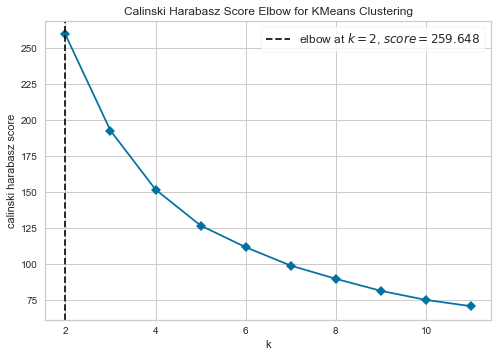

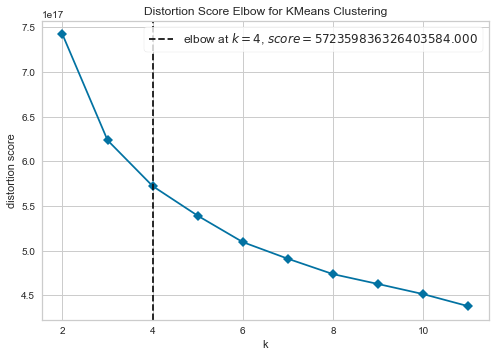

In [50]:
plotKElbow(cluster,cluster_value,'calinski_harabasz')
plotKElbow(cluster,cluster_value,'distortion')

In [201]:
kmeans_value=cluster_value.copy()

In [418]:
kmeans_value['kmeans_label']= kmeans_cluster(kmeans_value,3)

### MiniBatchKMeans


In [54]:
MiniBatch = MiniBatchKMeans(n_clusters=None,random_state=0)

C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\b

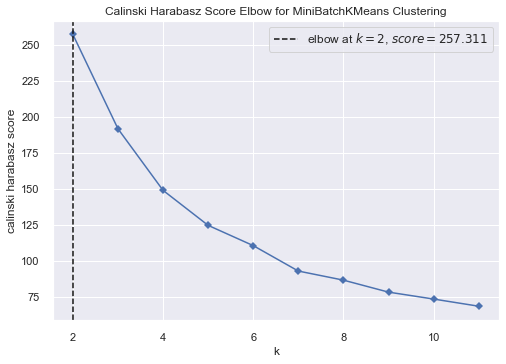

C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\b

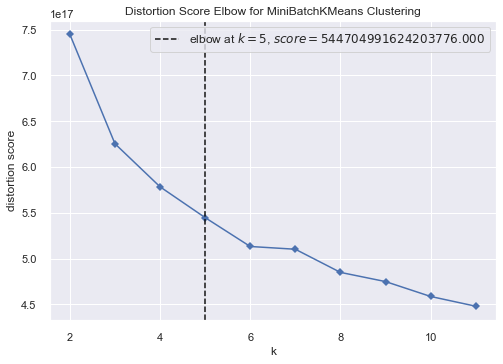

In [56]:
plotKElbow(MiniBatch,cluster_value,'calinski_harabasz')
plotKElbow(MiniBatch,cluster_value,'distortion')

In [153]:
miniBatch = MiniBatchKMeans(n_clusters=3, init='k-means++', n_init=15, random_state=1)
miniBatch_labels = miniBatch.fit_predict(cluster_value)

C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


In [154]:
miniBatch_value=cluster_value.copy()
miniBatch_value['miniBatch_labels']=miniBatch_labels

### HC

In [62]:
hc_value = cluster_value.copy()

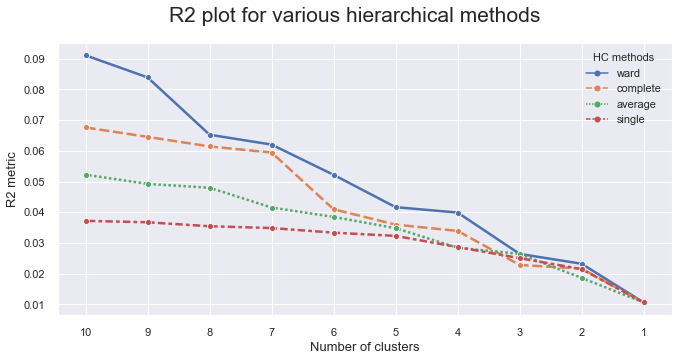

In [63]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack([get_r2_hc(hc_value, link_method=link, max_nclus=max_nclus) for link in hc_methods]).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

In [64]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclabel=hclust.fit_predict(hc_value)

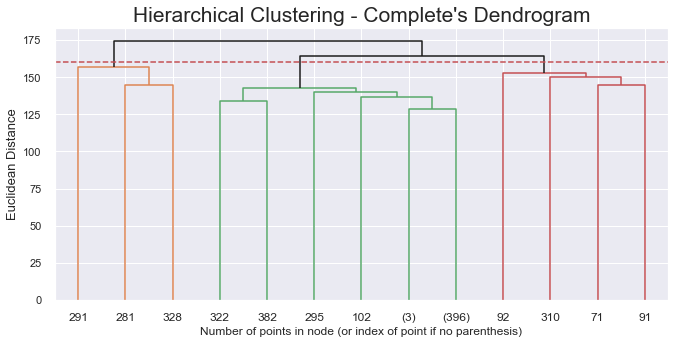

In [157]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold =160
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [158]:
hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')
hclabel=hierclust.fit_predict(hc_value)

In [159]:
hc_value['hc_labels']= hclabel

### R2 Avaliation By Value


In [160]:
r2_kmeans = plot_R2(kmeans_value, kmeans_value['kmeans_label'])
#r2_gmm = plot_R2(gmm_value,gmm_value['gmm_label'])
r2_hc = plot_R2(hc_value, hc_value['hc_labels'])
r2_miniBatch = plot_R2(miniBatch_value, miniBatch_value['miniBatch_labels'])

In [161]:
r2_solutions = [r2_kmeans,r2_miniBatch,r2_hc]
r2_solutions = np.asarray(r2_solutions)

<AxesSubplot:xlabel='Value', ylabel='Col'>

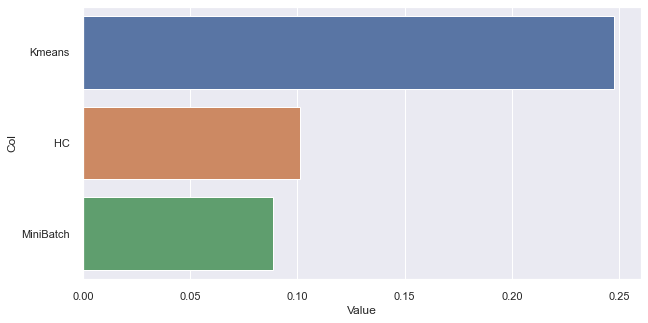

In [162]:
zippy = pd.DataFrame(zip(r2_solutions))
zippy['col'] = [ 'Kmeans', 'MiniBatch', ' HC']
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(10,5))
sns.barplot(y='Col', x='Value', data=tidy)

In [419]:
cluster_value = pd.read_csv('cluster_value.csv')
cluster_value.set_index('Point-of-Sale_ID',inplace=True)

In [420]:
final_value = pd.merge(cluster_value,kmeans_value['kmeans_label'],left_index=True,right_index=True)

In [421]:
final_value.rename(columns={'kmeans_label':'cluster_value'},inplace=True)

In [422]:
final_value.to_csv('final_value.csv')

In [423]:
final_value = pd.read_csv('final_value.csv')
final_value.set_index('Point-of-Sale_ID',inplace=True)

In [424]:
final_value.head()

('Value', 1)  ('Value', 2)  ('Value', 3)  ('Value', 4)  \
Point-of-Sale_ID                                                           
1                          0.0           0.0           0.0       20760.0   
2                          0.0           0.0        1740.0       17832.0   
3                          0.0        3242.0        1792.0        6976.0   
4                          0.0       14975.0       33272.0      101293.0   
5                          0.0           0.0        4905.0           0.0   

                  ('Value', 5)  ('Value', 6)  ('Value', 7)  ('Value', 8)  \
Point-of-Sale_ID                                                           
1                      29690.0       45700.0           0.0           0.0   
2                       3380.0       44100.0           0.0           0.0   
3                       4971.0        7363.0           0.0           0.0   
4                      20340.0      307052.0        1650.0        3000.0   
5                          0.0        8990.0           0.0        2750.0   

                  ('Value', 9)  ('Value', 10)  ...  ('Value', 2842)  \
Point-of-Sale_ID                               ...                    
1                          0.0            0.0  ...              0.0   
2                          0.0            0.0  ...              0.0   
3                      39878.0            0.0  ...              0.0   
4                      37080.0            0.0  ...              0.0   
5                      19600.0            0.0  ...              0.0   

                  ('Value', 2843)  ('Value', 2844)  ('Value', 2845)  \
Point-of-Sale_ID                                                      
1                             0.0              0.0         914584.0   
2                             0.0              0.0         261659.0   
3                             0.0              0.0         899528.0   
4                             0.0            638.0        1616587.0   
5                             0.0              0.0         688120.0   

                  ('Value', 2846)  ('Value', 2847)  ('Value', 2848)  \
Point-of-Sale_ID                                                      
1                       2506836.0     8.589670e+06          47352.0   
2                        505449.0     1.562870e+07         118112.0   
3                       1144853.0     2.169964e+07         381725.0   
4                       2944077.0     3.432967e+07         165136.0   
5                        991445.0     1.688569e+07          57156.0   

                  ('Value', 2849)  ('Value', 2850)  cluster_value  
Point-of-Sale_ID                                                   
1                         61767.0          44804.0              1  
2                         46383.0           2197.0              2  
3                             0.0          94903.0              2  
4                         41488.0          64577.0              1  
5                         66702.0          19773.0              2  

[5 rows x 2821 columns]

In [425]:
final_value[final_value['cluster_value']==0].mean().mean()

497706.86468433513

In [426]:
final_value[final_value['cluster_value']==1].mean().mean()

384693.5362543476

In [427]:
final_value[final_value['cluster_value']==2].mean().mean()

211731.91906479193

In [429]:
final_value.cluster_value.unique()

array([1, 2, 0], dtype=int64)

In [430]:
pca_value = final_value.drop('cluster_value',axis=1).copy()

In [431]:
pca = PCA(n_components=2)
pca_feat = pca.fit_transform(pca_value)
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=pca_value.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

PC0           PC1
Point-of-Sale_ID                            
1                 2.261705e+07 -3.122903e+06
2                -1.289749e+07 -7.669634e+06
3                 4.723996e+07 -1.982616e+07
4                 4.776584e+07 -2.695619e+06
5                -1.351265e+07  6.510021e+06
...                        ...           ...
406               2.813518e+06  4.600816e+07
407               7.066283e+07  7.406356e+07
408              -1.780445e+06  5.183683e+07
409               9.231301e+05  4.230919e+07
410               7.362702e+07  5.692146e+07

[410 rows x 2 columns]

In [432]:
pd.merge(pca_df,final_value['cluster_value'],left_index=True, right_index=True).to_csv('pca_value.csv')

In [433]:
pca_value = pd.read_csv('pca_value.csv')
pca_value.set_index('Point-of-Sale_ID',inplace=True)

In [467]:
def count_labels(df,label,columnToCount):
    d ={'Cluster':df.groupby(label)[columnToCount].count().index,'Count':df.groupby(label)[columnToCount].count().values}
    df =pd.DataFrame(data=d )
    fig = px.bar(df, x='Cluster', y='Count')
    return fig.show()

In [468]:
count_labels(pca_value,'cluster_value','PC0')

In [435]:
fig = px.scatter(pca_value, x="PC0", y="PC1", color="cluster_value", hover_data=[pca_value.index])
fig.show()

# Product Preferences

In [207]:
cluster_product=pd.pivot_table(data,index=["Point-of-Sale_ID"],values=["Units"],
               columns=["ProductName_ID"],aggfunc=[np.sum])

In [208]:
cluster_product.replace(np.nan,0,inplace=True)

In [209]:
cluster_product.columns= cluster_product.columns.droplevel(0)

In [210]:
cluster_product.columns.name = None        

In [211]:
cluster_product=pd.DataFrame(cluster_product.to_records())

In [213]:
cluster_product.to_csv('cluster_product.csv')

In [375]:
cluster_product =pd.read_csv('cluster_product.csv')

In [376]:
cluster_product.set_index('Point-of-Sale_ID',inplace=True)

In [377]:
cluster_product.head()

('Units', 1)  ('Units', 2)  ('Units', 3)  ('Units', 4)  \
Point-of-Sale_ID                                                           
1                          0.0           0.0           0.0          12.0   
2                          0.0           0.0           1.0          10.0   
3                          0.0           1.0           1.0           4.0   
4                          0.0           5.0          20.0          57.0   
5                          0.0           0.0           3.0           0.0   

                  ('Units', 5)  ('Units', 6)  ('Units', 7)  ('Units', 8)  \
Point-of-Sale_ID                                                           
1                         17.0          20.0           0.0           0.0   
2                          2.0          19.0           0.0           0.0   
3                          3.0           3.0           0.0           0.0   
4                         13.0         145.0           1.0           1.0   
5                          0.0           4.0           0.0           1.0   

                  ('Units', 9)  ('Units', 10)  ...  ('Units', 2841)  \
Point-of-Sale_ID                               ...                    
1                          0.0            0.0  ...            785.0   
2                          0.0            0.0  ...            508.0   
3                          4.0            0.0  ...            531.0   
4                          4.0            0.0  ...           1770.0   
5                          2.0            0.0  ...            734.0   

                  ('Units', 2842)  ('Units', 2843)  ('Units', 2844)  \
Point-of-Sale_ID                                                      
1                             0.0              0.0              0.0   
2                             0.0              0.0              0.0   
3                             0.0              0.0              0.0   
4                             0.0              0.0              1.0   
5                             0.0              0.0              0.0   

                  ('Units', 2845)  ('Units', 2846)  ('Units', 2847)  \
Point-of-Sale_ID                                                      
1                          1039.0           1530.0           1782.0   
2                           297.0            345.0           3274.0   
3                          1021.0            759.0           4553.0   
4                          1835.0           1903.0           7163.0   
5                           781.0            643.0           3533.0   

                  ('Units', 2848)  ('Units', 2849)  ('Units', 2850)  
Point-of-Sale_ID                                                     
1                            30.0             37.0             20.0  
2                            77.0             28.0              1.0  
3                           269.0              0.0             43.0  
4                           112.0             25.0             29.0  
5                            42.0             40.0              9.0  

[5 rows x 2820 columns]

In [400]:
scaler = StandardScaler().fit(cluster_product)
cluster_product=pd.DataFrame(scaler.transform(cluster_product),index=cluster_product.index, columns=cluster_product.columns)

### KMEANS

In [276]:
cluster = KMeans(random_state=0)

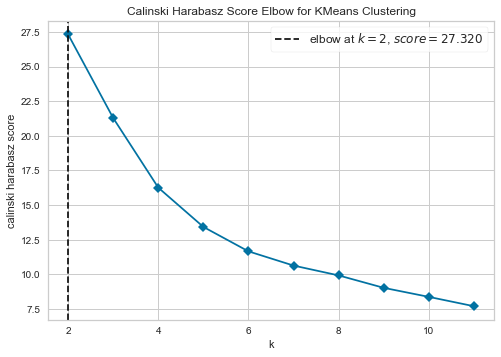

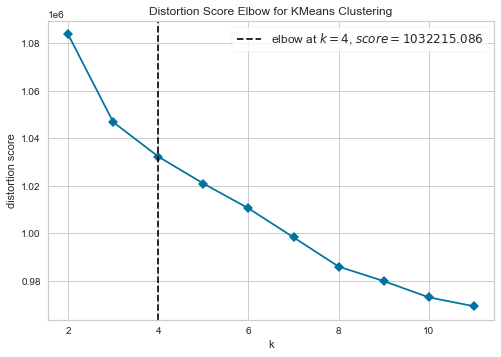

In [277]:
plotKElbow(cluster,cluster_product,'calinski_harabasz')
plotKElbow(cluster,cluster_product,'distortion')

In [401]:
kmeans_value=cluster_product.copy()

In [402]:
kmeans_value['kmeans_label']= kmeans_cluster(kmeans_value,3)

### MiniBatch

In [54]:
MiniBatch = MiniBatchKMeans(n_clusters=None,random_state=0)

C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\b

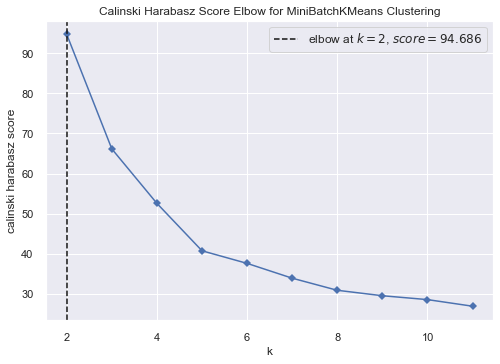

C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\b

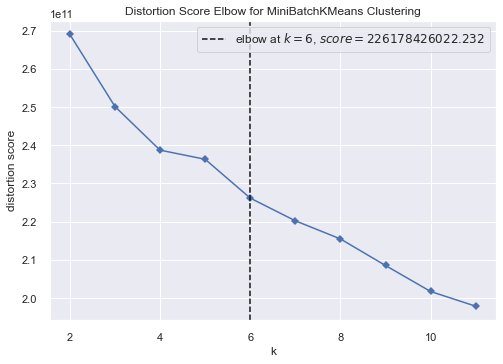

In [219]:
plotKElbow(MiniBatch,cluster_product,'calinski_harabasz')
plotKElbow(MiniBatch,cluster_product,'distortion')

In [212]:
miniBatch = MiniBatchKMeans(n_clusters=4, init='k-means++', n_init=15, random_state=1)
miniBatch_labels = miniBatch.fit_predict(cluster_product)

C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1



In [213]:
miniBatch_value=cluster_product.copy()
miniBatch_value['miniBatch_labels']=miniBatch_labels

### HC

In [214]:
hc_value = cluster_product.copy()

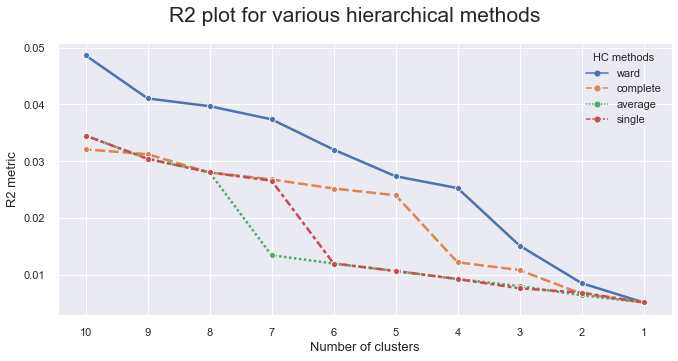

In [215]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack([get_r2_hc(hc_value, link_method=link, max_nclus=max_nclus) for link in hc_methods]).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

In [216]:
linkage = 'complete'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclabel=hclust.fit_predict(hc_value)

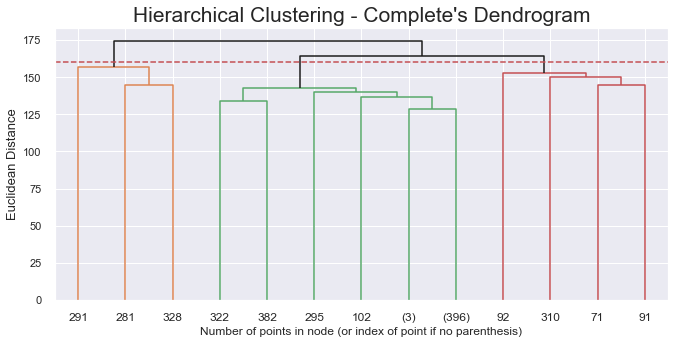

In [217]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold =160
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [218]:
hierclust = AgglomerativeClustering(n_clusters=3, linkage='ward')
hclabel=hierclust.fit_predict(hc_value)

In [219]:
hc_value['hc_labels']= hclabel

### R2 Avaliation By Product


In [220]:
r2_kmeans = plot_R2(kmeans_value, kmeans_value['kmeans_label'])
r2_hc = plot_R2(hc_value, hc_value['hc_labels'])
r2_miniBatch = plot_R2(miniBatch_value, miniBatch_value['miniBatch_labels'])

In [221]:
r2_solutions = [r2_kmeans,r2_miniBatch,r2_hc]
r2_solutions = np.asarray(r2_solutions)

<AxesSubplot:xlabel='Value', ylabel='Col'>

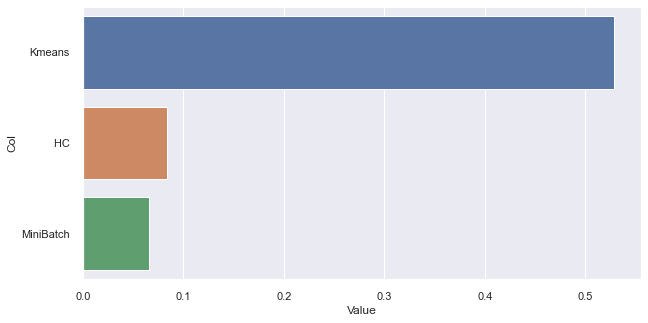

In [222]:
zippy = pd.DataFrame(zip(r2_solutions))
zippy['col'] = [ 'Kmeans', 'MiniBatch', ' HC']
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(10,5))
sns.barplot(y='Col', x='Value', data=tidy)

In [403]:
cluster_product = pd.read_csv('cluster_product.csv')
cluster_product.set_index('Point-of-Sale_ID',inplace=True)

In [404]:
final_product = pd.merge(cluster_product,kmeans_value['kmeans_label'],left_index=True,right_index=True)

In [405]:
final_product.rename(columns = {'kmeans_label':'cluster_product'},inplace=True)

In [406]:
final_product.to_csv('final_product.csv')

In [407]:
final_product =pd.read_csv('final_product.csv')
final_product.set_index('Point-of-Sale_ID',inplace=True)

In [408]:
pca = PCA(n_components=2)
pca_feat = pca.fit_transform(final_product.drop('cluster_product',axis=1))
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=final_product.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

PC0           PC1
Point-of-Sale_ID                            
1                  9429.318634    456.488656
2                 -7058.023599  -7196.865787
3                  5230.756417  -3704.429375
4                 17052.233168  -3492.207682
5                 -3155.564065  -6129.768477
...                        ...           ...
406                3738.034269  37349.347736
407               25199.447392  35085.646149
408                2274.010880  32003.973709
409               -1186.426702  14419.255925
410               29962.614883  36096.695401

[410 rows x 2 columns]

In [409]:
pd.merge(pca_df,final_product['cluster_product'],left_index=True, right_index=True).to_csv('pca_product.csv')

In [410]:
pca_product = pd.read_csv('pca_product.csv')
pca_product.set_index('Point-of-Sale_ID',inplace=True)

In [466]:
pca_product

PC0           PC1  cluster_product
Point-of-Sale_ID                                             
1                  9429.318634    456.488656                1
2                 -7058.023599  -7196.865787                2
3                  5230.756417  -3704.429375                2
4                 17052.233168  -3492.207682                1
5                 -3155.564065  -6129.768477                2
...                        ...           ...              ...
406                3738.034269  37349.347736                2
407               25199.447392  35085.646149                1
408                2274.010880  32003.973709                2
409               -1186.426702  14419.255925                2
410               29962.614883  36096.695401                1

[410 rows x 3 columns]

In [411]:
fig = px.scatter(pca_product, x="PC0", y="PC1", color="cluster_product", hover_data=[pca_product.index])
fig.show()

In [471]:
count_labels(pca_product,'cluster_product','PC0')

In [398]:
final_product[final_product['cluster_product']==0].mean().sort_values(ascending=False).head(10)

('Units', 1277)    7006.736686
('Units', 2609)    6684.162722
('Units', 481)     6294.852071
('Units', 993)     5994.535503
('Units', 1147)    5766.248521
('Units', 2802)    5623.973373
('Units', 847)     5472.763314
('Units', 1234)    5399.165680
('Units', 226)     5321.621302
('Units', 1422)    5170.405325
dtype: float64

In [399]:
final_product[final_product['cluster_product']==1].mean().sort_values(ascending=False).head(10)

('Units', 481)     11888.263889
('Units', 1147)    11835.555556
('Units', 993)     11273.861111
('Units', 2609)    11271.111111
('Units', 1277)    11143.986111
('Units', 567)      9875.388889
('Units', 1234)     9769.180556
('Units', 1422)     9263.388889
('Units', 226)      8878.944444
('Units', 2802)     8622.500000
dtype: float64

In [473]:
final_product[final_product['cluster_product']==2].mean().sort_values(ascending=False).head(10).values 

array([6170.33079848, 5778.35741445, 5356.04942966, 5185.25095057,
       5181.79087452, 4900.33840304, 4876.48669202, 4602.29277567,
       4478.76045627, 4428.04942966])

In [ ]:
def count_labels(df,label,columnToCount):
    d ={'Cluster':df.groupby(label)[columnToCount].count().index,'Count':df.groupby(label)[columnToCount].count().values}
    df =pd.DataFrame(data=d )
    fig = px.bar(df, x='Cluster', y='Count')
    return fig.show()

In [475]:
def plot_top10(clusterNumber):
    d ={'Products':final_product[final_product['cluster_product']==clusterNumber].mean().sort_values(ascending=False).head(10).index,'Mean Sold':final_product[final_product['cluster_product']==clusterNumber].mean().sort_values(ascending=False).head(10).values}
    df =pd.DataFrame(data=d )
    fig = px.bar(df, x='Products', y='Mean Sold')
    return fig.show()

In [478]:
plot_top10(0)

## Data frame with clusters and PS

In [346]:
clusters=pd.merge(final_product['cluster_product'],final_value['cluster_value'],left_index=True,right_index=True)

In [347]:
clusters.to_csv('clusters.csv')

In [348]:
clusters= pd.read_csv('clusters.csv')
clusters.set_index('Point-of-Sale_ID',inplace=True)

In [349]:
clusters.head(20)

cluster_product  cluster_value
Point-of-Sale_ID                                
1                               1              2
2                               2              0
3                               2              0
4                               1              2
5                               2              0
6                               2              0
7                               2              0
8                               1              2
9                               2              0
10                              2              0
11                              1              0
12                              2              0
13                              1              2
14                              2              0
15                              2              0
16                              1              2
17                              1              2
18                              2              0
19                              1              0
20                              2              0